In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm 
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential ,Model
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D,Input


In [3]:
BASE_DIR = 'D:/age_gender/UTKFace'

In [4]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

100%|██████████| 23708/23708 [00:00<00:00, 301553.76it/s]


In [5]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  D:/age_gender/UTKFace\100_0_0_2017011221350090...  100       0
1  D:/age_gender/UTKFace\100_0_0_2017011221524034...  100       0
2  D:/age_gender/UTKFace\100_1_0_2017011018372639...  100       1
3  D:/age_gender/UTKFace\100_1_0_2017011221300198...  100       1
4  D:/age_gender/UTKFace\100_1_0_2017011221330369...  100       1

In [11]:
gender_dict = {0:'Male', 1:'Female'}

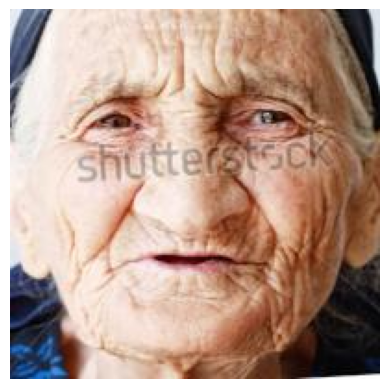

In [6]:
from PIL import Image
img = Image.open(df['image'][2])
plt.axis('off')
plt.imshow(img);


<Axes: xlabel='age', ylabel='Density'>

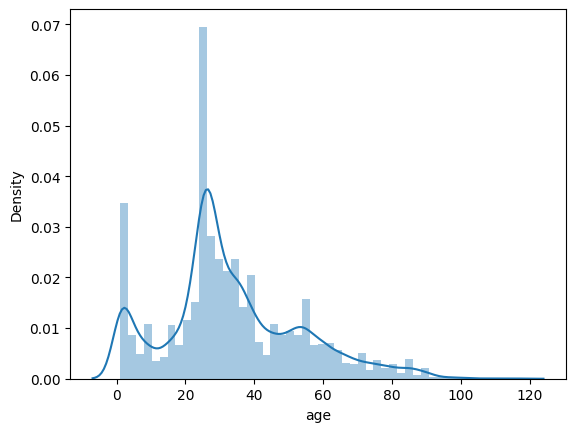

In [10]:
sns.distplot(df['age'])

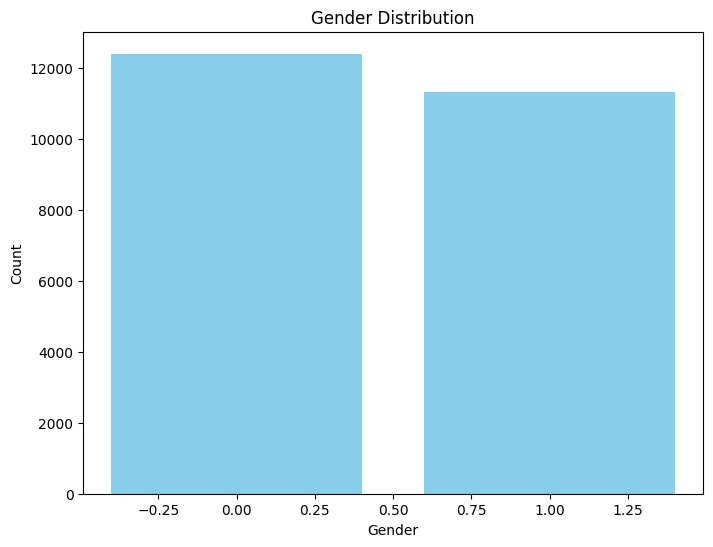

In [8]:
gender_counts = df['gender'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))

plt.bar(gender_counts.index, gender_counts.values, color='skyblue')

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')

# Show plot
plt.show()

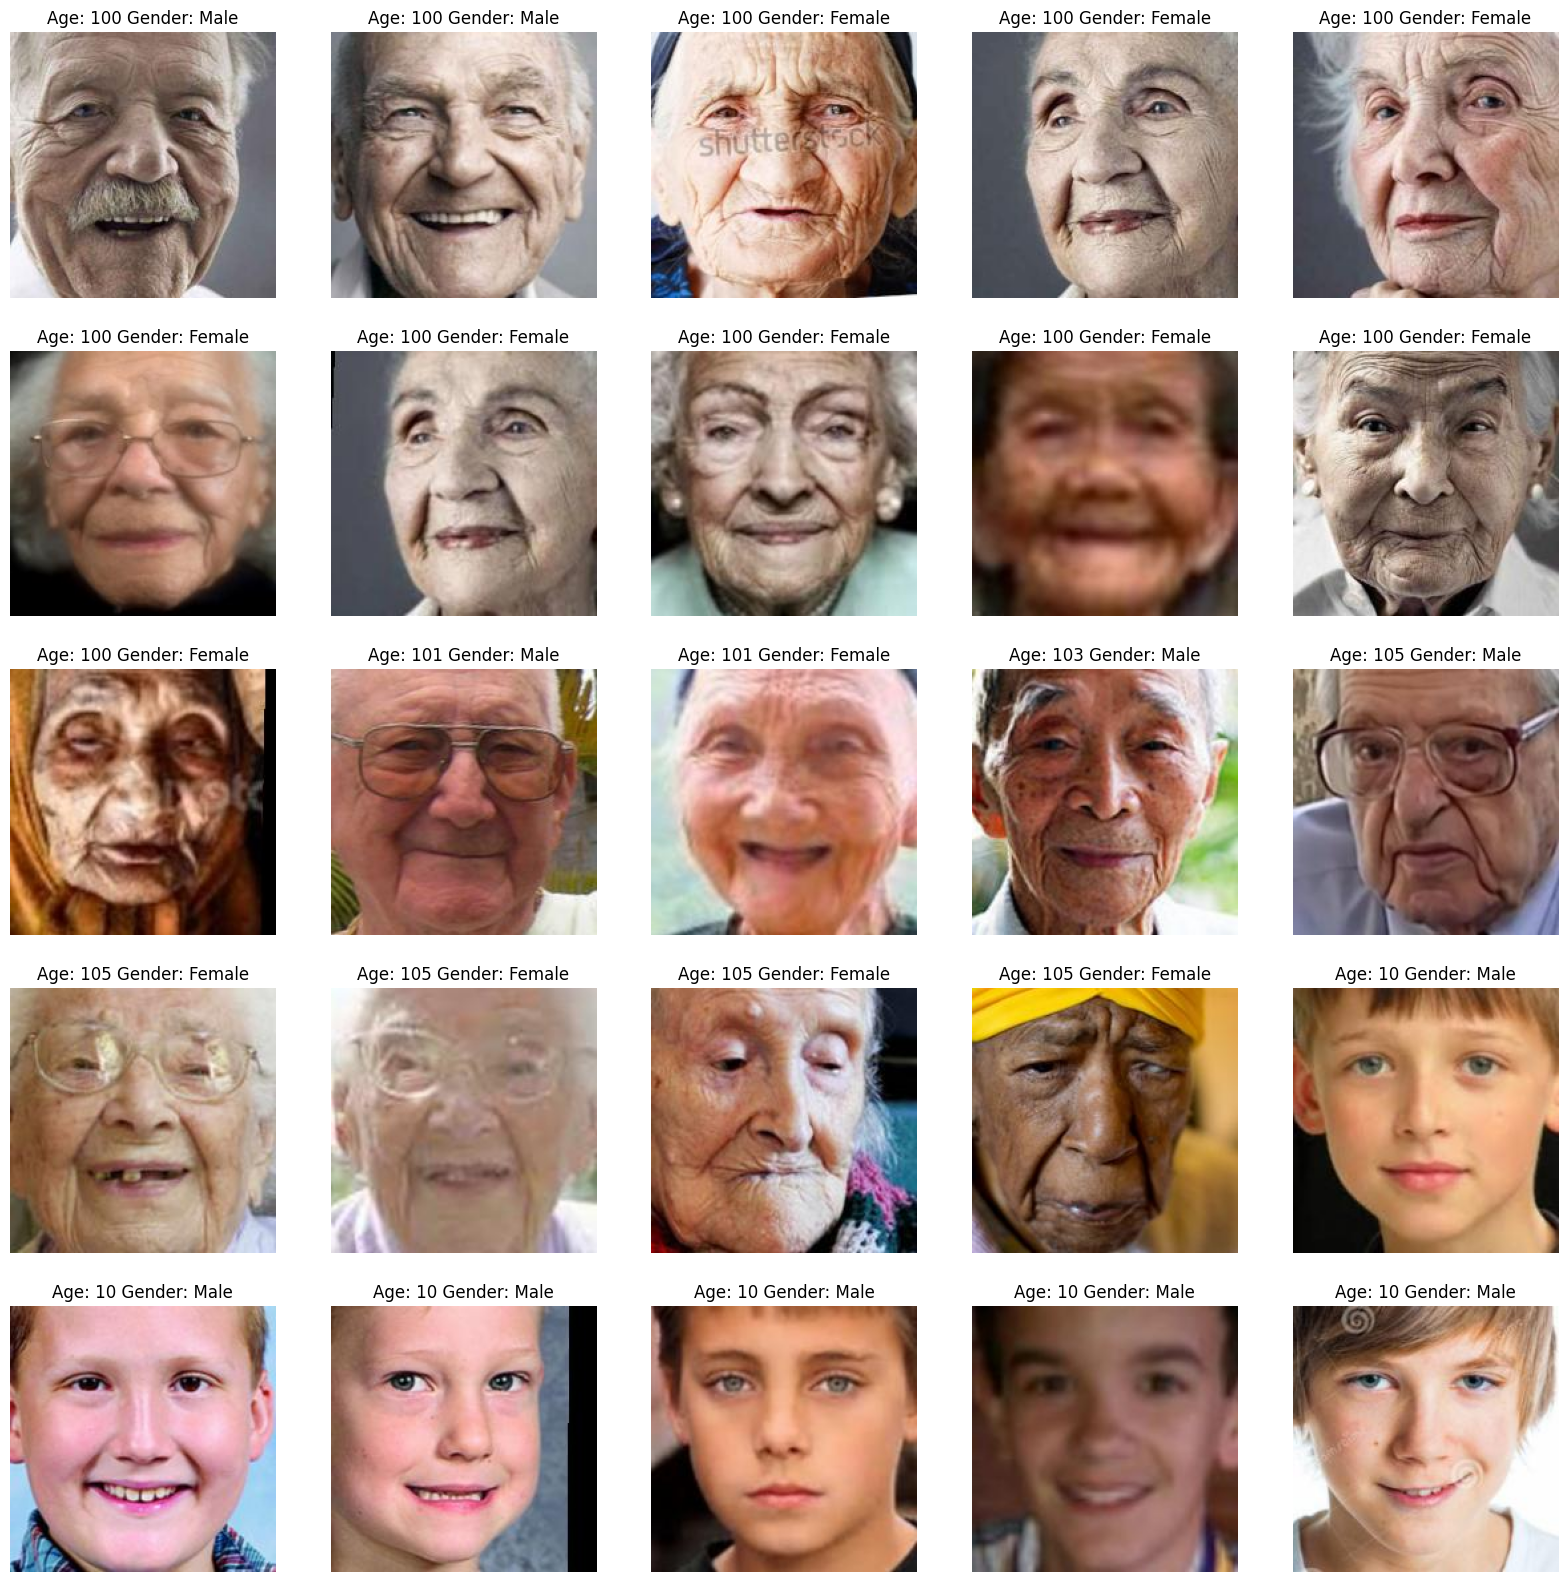

In [12]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [13]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img) 
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [15]:
from PIL import Image

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = Image.open(image).convert('L')  # Open image and convert to grayscale
        img = img.resize((128, 128))  # Resize without specifying ANTIALIAS
        img = np.array(img) 
        features.append(img)
    return np.array(features)

X = extract_features(df['image'])


100%|██████████| 23708/23708 [01:15<00:00, 315.47it/s] 


In [17]:
X.shape

(23708, 128, 128)

In [18]:
X = X/255.0

In [19]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [20]:
input_shape = (128, 128, 1)

In [21]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [26]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=2, validation_split=0.2)

Epoch 1/2
593/593 [==============================] - 375s 629ms/step - loss: 10.9391 - gender_out_loss: 0.6878 - age_out_loss: 10.2512 - gender_out_accuracy: 0.5446 - age_out_accuracy: 0.0588 - val_loss: 32.1561 - val_gender_out_loss: 0.5731 - val_age_out_loss: 31.5830 - val_gender_out_accuracy: 0.7048 - val_age_out_accuracy: 0.0000e+00
Epoch 2/2
593/593 [==============================] - 1305s 2s/step - loss: 8.0932 - gender_out_loss: 0.4886 - age_out_loss: 7.6047 - gender_out_accuracy: 0.7601 - age_out_accuracy: 0.0438 - val_loss: 28.3367 - val_gender_out_loss: 0.5106 - val_age_out_loss: 27.8260 - val_gender_out_accuracy: 0.7531 - val_age_out_accuracy: 0.0000e+00


In [22]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


NameError: name 'history' is not defined

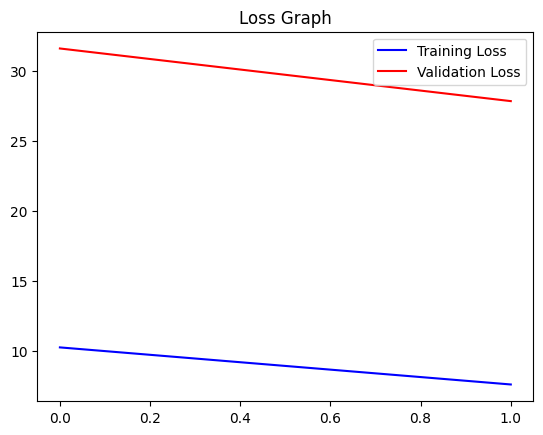

In [28]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 10
1/1 [==============================] - 0s 220ms/step
Predicted Gender: Female Predicted Age: 30


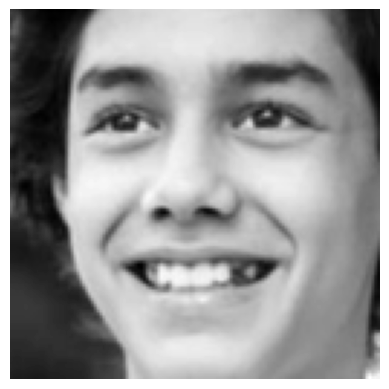

In [29]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 21
1/1 [==============================] - 0s 42ms/step
Predicted Gender: Male Predicted Age: 24


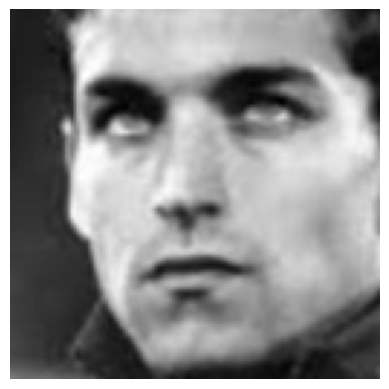

In [30]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 29
1/1 [==============================] - 0s 30ms/step
Predicted Gender: Female Predicted Age: 28


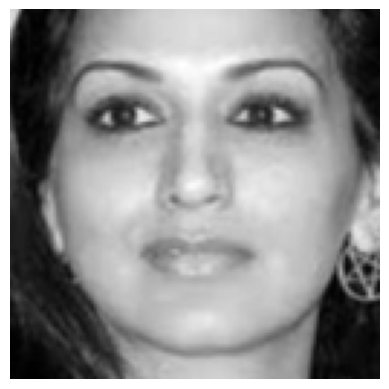

In [31]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

1/1 [==============================] - 0s 174ms/step


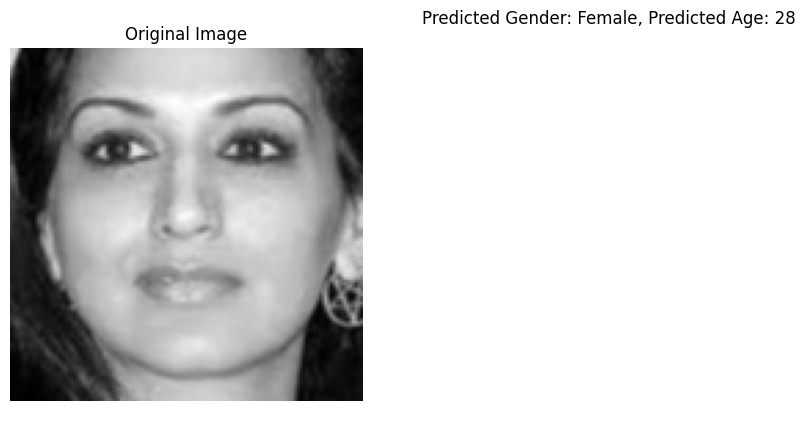

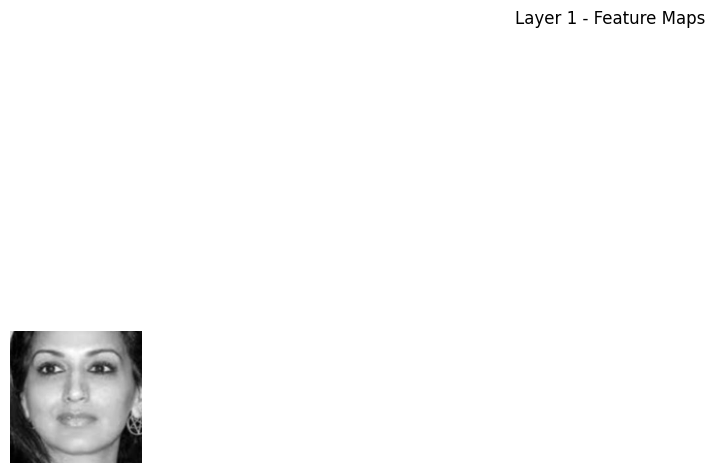

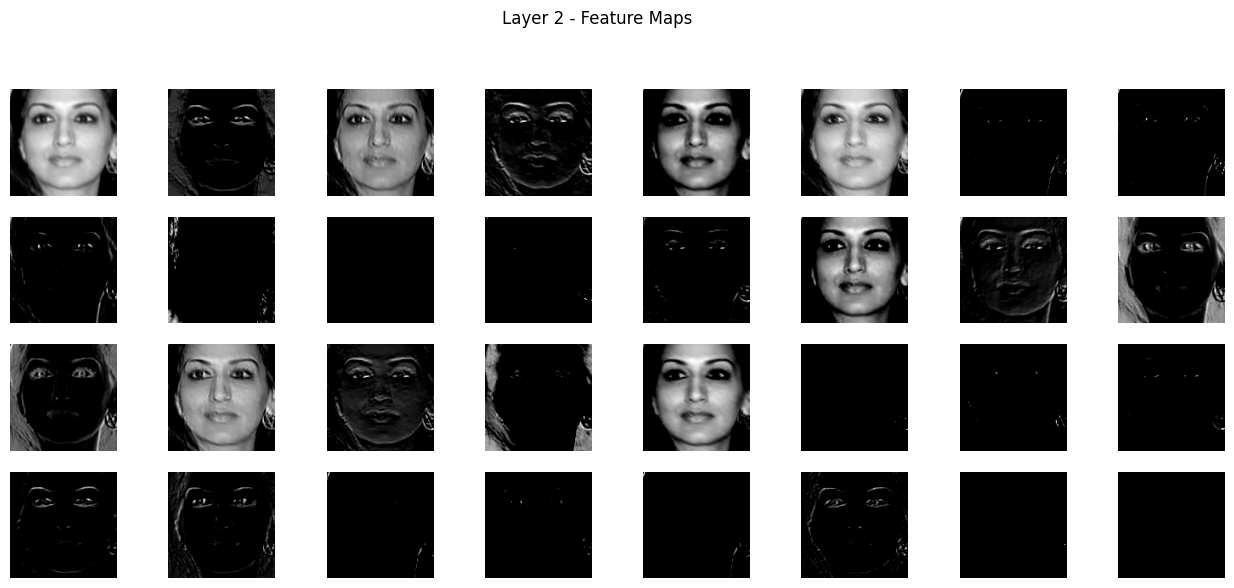

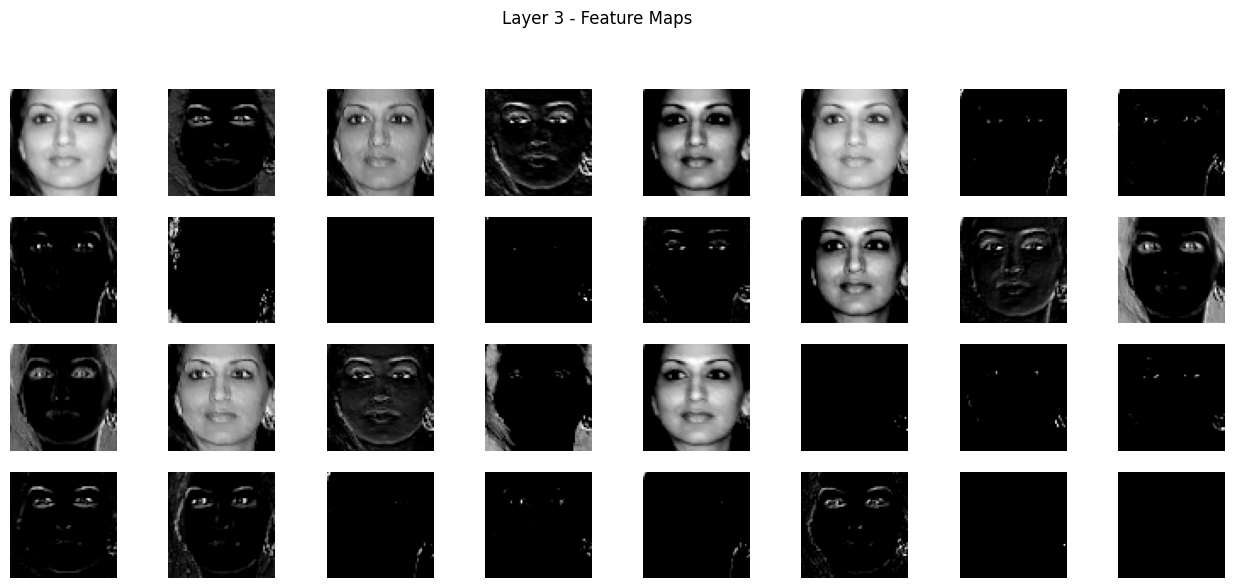

In [34]:
image_index = 10000

# Get the output of intermediate layers
layer_outputs = [layer.output for layer in model.layers]

# Create a model that returns the activations of intermediate layers
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get activations for a specific image
activations = activation_model.predict(X[image_index].reshape(1, 128, 128, 1))

# Plot the original image and its predicted gender and age
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
# Predict gender and age from the model
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
plt.title(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")
plt.axis('off')

# Visualize the feature maps
for layer_index, activation in enumerate(activations[:3]):
    if len(activation.shape) == 4:  # Check if the activation is a feature map
        num_features = activation.shape[-1]  # Number of features in the activation
        num_cols = 8 # Number of columns for displaying the feature maps
        num_rows = num_features // num_cols + 1

        # Plot the feature maps
        plt.figure(figsize=(16, 8))
        for feature_index in range(num_features):
            plt.subplot(num_rows, num_cols, feature_index + 1)
            plt.imshow(activation[0, :, :, feature_index], cmap='gray')
            plt.axis('off')
        plt.suptitle(f'Layer {layer_index+1} - Feature Maps')
        plt.show()

plt.show()


In [1]:
image_index = 2


# Get the output of intermediate layers
layer_outputs = [layer.output for layer in model.layers]

# Create a model that returns the activations of intermediate layers
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get activations for a specific image
activations = activation_model.predict(X[image_index].reshape(1, 128, 128, 1))

# Plot the original image and its predicted gender and age
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
# Predict gender and age from the model
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
plt.title(f"Predicted Gender: {pred_gender}, Predicted Age: {pred_age}")
plt.axis('off')

# Print original gender and age
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])

# Visualize the feature maps
for layer_index, activation in enumerate(activations[:3]):
    if len(activation.shape) == 4:  # Check if the activation is a feature map
        num_features = activation.shape[-1]  # Number of features in the activation
        num_cols = 8 # Number of columns for displaying the feature maps
        num_rows = num_features // num_cols + 1

        # Plot the feature maps
        plt.figure(figsize=(16, 8))
        for feature_index in range(num_features):
            plt.subplot(num_rows, num_cols, feature_index + 1)
            plt.imshow(activation[0, :, :, feature_index], cmap='gray')
            plt.axis('off')
        plt.suptitle(f'Layer {layer_index+1} - Feature Maps')
        plt.show()

plt.show()

NameError: name 'model' is not defined

In [ ]:
model.save('model.h5')